In [1]:
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
import numpy as np

Mounted at /content/drive


In [2]:
train = pd.read_csv('/content/drive/MyDrive/NLP/Train (2).csv')
test = pd.read_csv('/content/drive/MyDrive/NLP/Test.csv')
VariableDefinitions = pd.read_csv('/content/drive/MyDrive/NLP/VariableDefinitions.csv')
sample_submission = pd.read_csv('/content/drive/MyDrive/NLP/SampleSubmission.csv')

In [3]:
train.head()

,id,content,category
0,SW0,SERIKALI imesema haitakuwa tayari kuona amani...,Kitaifa
1,SW1,"Mkuu wa Mkoa wa Tabora, Aggrey Mwanri amesiti...",Biashara
2,SW10,SERIKALI imetoa miezi sita kwa taasisi zote z...,Kitaifa
3,SW100,KAMPUNI ya mchezo wa kubahatisha ya M-bet ime...,michezo
4,SW1000,WATANZANIA wamekumbushwa kusherehekea sikukuu...,Kitaifa


In [4]:
test.head()

,swahili_id,content
0,001dd47ac202d9db6624a5ff734a5e7dddafeaf2,"MKUU wa Wilaya ya Bahi, Mkoani Dodoma, Mwanah..."
1,0043d97f7690e9bc02f0ed8bb2b260d1d44bad92,"MWISHONI mwa wiki hii, Timu ya Soka ya Taifa,..."
2,00579c2307b5c11003d21c40c3ecff5e922c3fd8,THAMANI ya mauzo ya bidhaa za Afrika Masharik...
3,00868eeee349e286303706ef0ffd851f39708d37,MENEJA Mawasiliano na Utetezi wa asasi ya AGP...
4,00a5cb12d3058dcf2e42f277eee599992db32412,"WAZIRI wa Kilimo, Japhet Hasunga amesema seri..."


## Defining the Problem

> Add blockquote



# I. Problem statement
Develop a multi-class classification model to classify news content according to their specific categories. The model can be used by swahili online platforms to automatically group news according to their categories and help readers find the specific news they want to read. In addition, the model will contributeto a body of work ensuring that swahili is represented in apps and other online products in future

# II. Defining the Metric for Success
1. The model achieves 80% accuracy
2. Be able to classify the news based on 5 categories specified

# Background

Swahili is spoken by 100-500 million people

# Experimental procedures
1. loading the data
2. Features and target variables understanding
3. Data Preprocessing
4. WordCloud
5. Label encoding
6. Word embedding
7. Model development

*   Term Frequency- Inverse Document Frequency(TF-IDF).
*   Long Short Term Memories (LSTMs).
*   Convolution Neural Networks (CNNs).
*   Transformers.

8. Validation
9. Conclusion


III. Data
The dataset describes 6439 rows of news from different sources in Tanzania.These news are in 5 different news categories from national news to entertainment news, (Kitaifa, Kimataifa, Michezo, Burudani, Biashara).

Data Source:
https://zindi.africa/competitions/swahili-news-classification/data


In [5]:
test.shape

(1288, 2)

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud, STOPWORDS
import pandas as pd
import numpy as np
import string
import re
import os
import warnings
warnings.filterwarnings('ignore')

#Data Visualization

In [7]:
train.dtypes

,0
id,object
content,object
category,object


In [8]:
train.shape

(5151, 3)

In [9]:
train['category'].unique()

array(['Kitaifa', 'Biashara', 'michezo', 'Kimataifa', 'Burudani'],
      dtype=object)

In [10]:
train.isnull().sum()

,0
id,0
content,0
category,0


<Axes: xlabel='category', ylabel='count'>

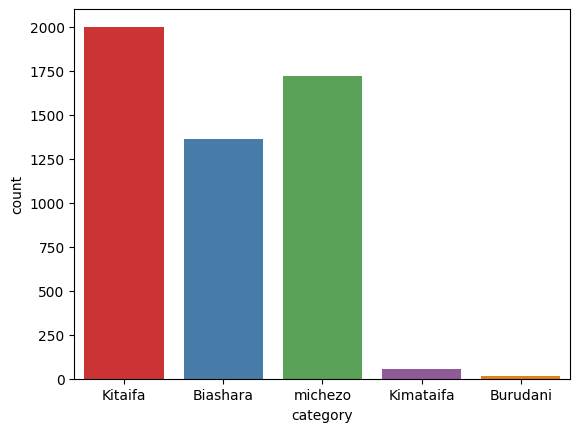

In [11]:
sns.countplot(x=train['category'],palette='Set1')

In [12]:
train['News_length'] = train['content'].str.len()
print(train['News_length'])

0       1584
1       1317
2       2610
3       1404
4       2247
        ... 
5146    6742
5147    2348
5148    3014
5149    1216
5150    1889
Name: News_length, Length: 5151, dtype: int64


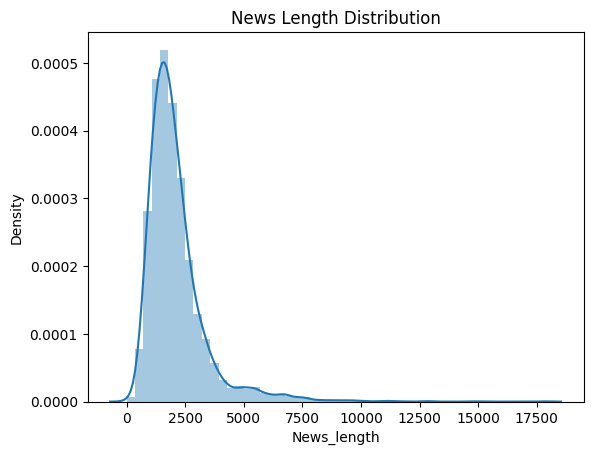

In [13]:
sns.distplot(train['News_length']).set_title('News Length Distribution');


# Data Cleaning
### Removing special characters
### Removing Punctuation and Stopwords

In [14]:

# Convert text to lowercase
train['content'] = train['content'].str.lower()

# Remove all non-alphabetic characters (including numbers)
train['content'] = train['content'].str.replace(r"[^a-zA-Z]", " ", regex=True)

# Remove extra spaces (optional but recommended)
train['content'] = train['content'].str.replace(r"\s+", " ", regex=True).str.strip()

# Display the cleaned text
print(train)

          id                                            content  category  \
0        SW0  serikali imesema haitakuwa tayari kuona amani ...   Kitaifa   
1        SW1  mkuu wa mkoa wa tabora aggrey mwanri amesitish...  Biashara   
2       SW10  serikali imetoa miezi sita kwa taasisi zote za...   Kitaifa   
3      SW100  kampuni ya mchezo wa kubahatisha ya m bet imei...   michezo   
4     SW1000  watanzania wamekumbushwa kusherehekea sikukuu ...   Kitaifa   
...      ...                                                ...       ...   
5146   SW993  rais john magufuli ameendelea kung ara katika ...   Kitaifa   
5147   SW994  kampeni inayohimiza watafi ti kuandika upya hi...   Kitaifa   
5148   SW996  matukio mapya ya malaria kwa kila watu katika ...   Kitaifa   
5149   SW997  imeelezwa kuwa hakuna sheria yoyote inayokataz...   Kitaifa   
5150   SW999  akizungumza mara baada ya kutiwa saini kwa mak...  Biashara   

      News_length  
0            1584  
1            1317  
2            26

#function to clean text

In [15]:
import re
import nltk
from nltk.tokenize import word_tokenize

nltk.download('punkt')  # Ensure tokenizer is downloaded

def clean_text(sentence):
    """ Function to clean content column, making it ready for transformation and modeling """

    sentence = sentence.lower()  # Convert text to lowercase
    sentence = re.sub('â€˜', '', sentence)  # Remove unwanted character
    sentence = re.sub('[‘’“”…,]', '', sentence)  # Remove punctuation
    sentence = re.sub('[()]', '', sentence)  # Remove parentheses
    sentence = re.sub(r"[^a-zA-Z\s]", " ", sentence)  # Keep only text (removes numbers, special chars)

    sentence = word_tokenize(sentence)  # Tokenize words
    sentence = [re.sub(r'(.)\1+', r'\1', word) for word in sentence]  # Remove repeated characters

    return " ".join(sentence)  # Convert list back to string


print(clean_text)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


<function clean_text at 0x7927fe004d60>


In [16]:
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [17]:
# % Applying our clean_text function on contents
train['content'] = train['content'].apply(clean_text)
train.head()

,id,content,category,News_length
0,SW0,serikali imesema haitakuwa tayari kuona amani ...,Kitaifa,1584
1,SW1,mku wa mkoa wa tabora agrey mwanri amesitisha ...,Biashara,1317
2,SW10,serikali imetoa miezi sita kwa tasisi zote za ...,Kitaifa,2610
3,SW100,kampuni ya mchezo wa kubahatisha ya m bet imei...,michezo,1404
4,SW1000,watanzania wamekumbushwa kusherehekea sikuku y...,Kitaifa,2247


In [18]:
train.head()

,id,content,category,News_length
0,SW0,serikali imesema haitakuwa tayari kuona amani ...,Kitaifa,1584
1,SW1,mku wa mkoa wa tabora agrey mwanri amesitisha ...,Biashara,1317
2,SW10,serikali imetoa miezi sita kwa tasisi zote za ...,Kitaifa,2610
3,SW100,kampuni ya mchezo wa kubahatisha ya m bet imei...,michezo,1404
4,SW1000,watanzania wamekumbushwa kusherehekea sikuku y...,Kitaifa,2247


#Lemmitization
 It standardizes words while keeping their original meaning

In [19]:
import nltk

# Download the 'punkt_tab' data package
nltk.download('punkt_tab')

word = []
for i in train['content']:
    word.append(nltk.word_tokenize(i))

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [20]:
# creating swahili stopwords list
filter_sent=[]
stopwords_swahili=["akasema","alikuwa","amesema","alisema","ambayo","ambapo","ambao","baada","basi","bila","cha","chini","hadi","hapo","hata",
                   "hivyo","hiyo","huku","huo","ili","ilikuwa","juu","kama","karibu","katika","kila",
                   "kima","kisha","kubwa","kutoka","kutokana","kwani","kuwa","kwa","kwamba","kwenda","kwenye","la",
                   "lakini","mara","mdogo","mimi","mkubwa","mmoja","moja","muda","mwenye","na",
                   "naye","ndani","ng","ni","nini","nonkungu","pamoja","pia","sana","sasa","sauti",
                   "tafadhali","tena","tu","vile","wa","wakati","wake","walikuwa","wao","watu","wengine",
                   "wote","ya","yake","yangu","yao","yeye","yule","za","zaidi","zake"]
for i in word:
    l=[]
    for j in i:
        if j not in stopwords_swahili:
            l.append(j) # This method appends an element to the end of the list
    filter_sent.append(' '.join(l))


In [21]:
train['content']=filter_sent

In [22]:
train.tail()

,id,content,category,News_length
5146,SW993,rais john magufuli amendelea kung ara siasa ki...,Kitaifa,6742
5147,SW994,kampeni inayohimiza watafi ti kuandika upya hi...,Kitaifa,2348
5148,SW996,matukio mapya malaria jami yamepungua asilimia...,Kitaifa,3014
5149,SW997,imelezwa hakuna sheria yoyote inayokataza tari...,Kitaifa,1216
5150,SW999,akizungumza bada kutiwa saini makubaliano hayo...,Biashara,1889


## WordCloud : is an image composed of words used in a particular text or subjectin which size of each word indicates its frequency or importance of that particular word

In [23]:
# Download necessary NLTK data
nltk.download('wordnet')
nltk.download('omw-1.4')

#initialize the wordnet Lemmatizer
lemmatizer = WordNetLemmatizer()

# Apply lemmatization to the 'content' column
train['content'] = train['content'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split()]))

# Display the lemmatized text
print(train.head())

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


       id                                            content  category  \
0     SW0  serikali imesema haitakuwa tayari kuona amani ...   Kitaifa   
1     SW1  mku mkoa tabora agrey mwanri amesitisha likizo...  Biashara   
2    SW10  serikali imetoa miezi sita tasisi zote uma amb...   Kitaifa   
3   SW100  kampuni mchezo kubahatisha m bet imeingia maku...   michezo   
4  SW1000  watanzania wamekumbushwa kusherehekea sikuku k...   Kitaifa   

   News_length  
0         1584  
1         1317  
2         2610  
3         1404  
4         2247  


In [24]:

def create_wordcloud(words):
  wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(words)
  plt.figure(figsize=(10, 7))
  plt.imshow(wordcloud, interpolation="bilinear")
  plt.axis('off')
  plt.show()

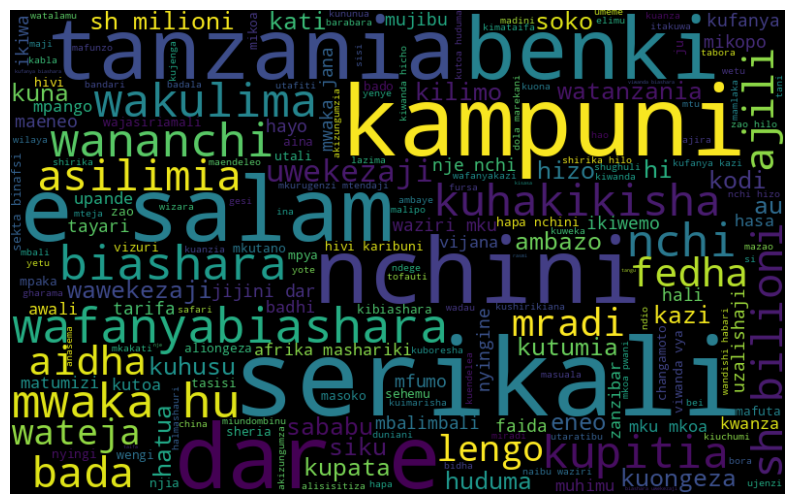

In [25]:

subset = train[train.category == 'Biashara']
text = subset.content.values
words= " ".join(text)
create_wordcloud(words)

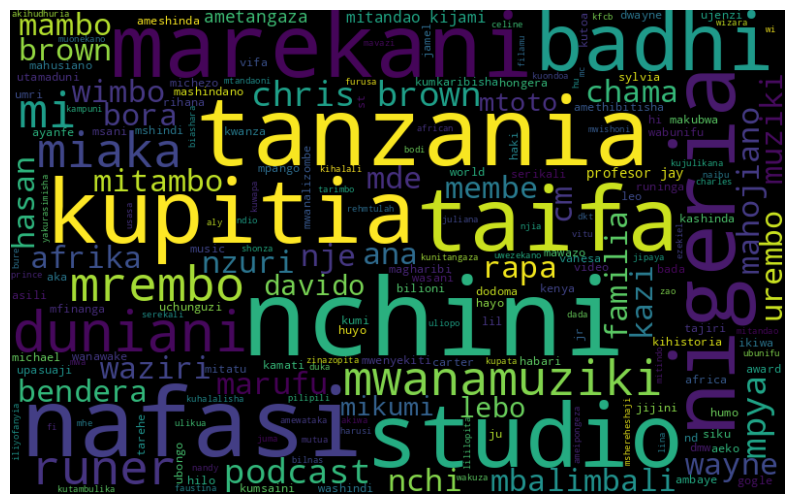

In [26]:

subset = train[train.category == 'Burudani']
text = subset.content.values
words= " ".join(text)
create_wordcloud(words)

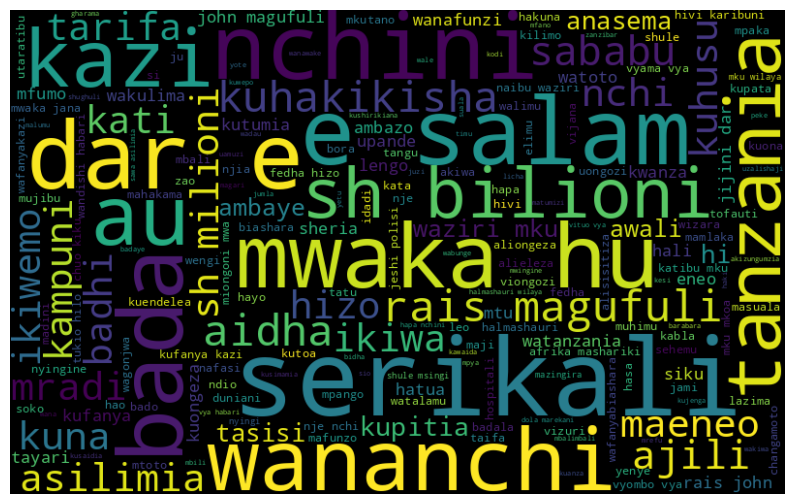

In [27]:

subset = train[train.category == 'Kitaifa']
text = subset.content.values
words= " ".join(text)
create_wordcloud(words)

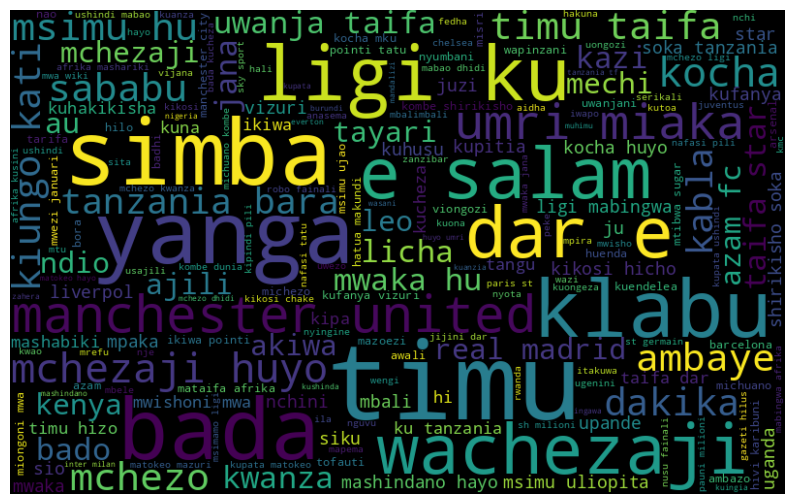

In [28]:

subset = train[train.category == 'michezo']
text = subset.content.values
words= " ".join(text)
create_wordcloud(words)

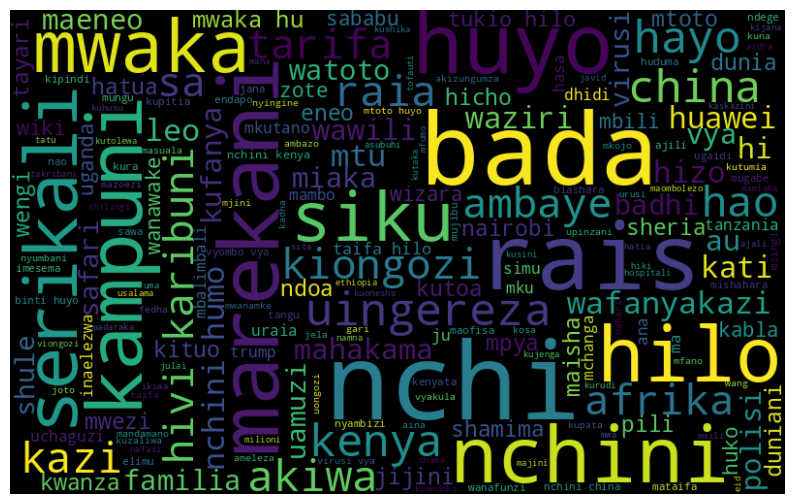

In [29]:
subset = train[train.category == 'Kimataifa']
text = subset.content.values
words= " ".join(text)
create_wordcloud(words)

## Label Encoding

In [30]:
from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()
train['category']= label_encoder.fit_transform(train['category'])
train.head()

,id,content,category,News_length
0,SW0,serikali imesema haitakuwa tayari kuona amani ...,3,1584
1,SW1,mku mkoa tabora agrey mwanri amesitisha likizo...,0,1317
2,SW10,serikali imetoa miezi sita tasisi zote uma amb...,3,2610
3,SW100,kampuni mchezo kubahatisha m bet imeingia maku...,4,1404
4,SW1000,watanzania wamekumbushwa kusherehekea sikuku k...,3,2247


In [31]:
x_train, X_test, y_train, y_test = train_test_split(train['content'], train['category'], test_size=0.2, random_state=42)

# Word embedding
* Is a technique in Natural Language Processing (NLP) where words are represented as numerical vectors in a continuous vector space. These representations capture the meaning of words, their relationships, and their context in a way that computers can understand

* What is TF-IDF in Word Embedding?
* TF-IDF (Term Frequency-Inverse Document Frequency) is a statistical technique used in Natural Language Processing (NLP) to represent words numerically based on their importance in a document relative to a collection of documents (corpus). It is an alternative to word embeddings like Word2Vec or GloVe, but it does not capture semantic meaning in the same way.

* How TF-IDF Works
TF-IDF assigns a weight to each word in a document based on:

### Term Frequency (TF)
Term Frequency measures how often a word appears in a document:
\begin{equation}
TF(w) = \frac{\text{Number of times word } w \text{ appears in a document}}{\text{Total words in the document}}
\end{equation}
Words that appear frequently in a document receive higher TF scores.

### Inverse Document Frequency (IDF)
Inverse Document Frequency measures how rare or important a word is across all documents:
\begin{equation}
IDF(w) = \log \left( \frac{\text{Total number of documents}}{\text{Number of documents containing word } w} \right)
\end{equation}
### TF-IDF Score Calculation
The final TF-IDF score for a word \( w \) is given by:
\begin{equation}
TF\text{-}IDF(w) = TF(w) \times IDF(w)
\end{equation}

In [32]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [33]:
ngram_range = (1,2)
min_df = 10
max_df = 1
max_features = 300


# TF-IDF Vectorizer
tfidf = TfidfVectorizer(encoding='utf-8',
                        ngram_range=ngram_range,
                        stop_words=None,
                        lowercase=False,
                        min_df=min_df,
                        max_features= max_features,
                        norm = 'l2',  # Change '12' to 'l2' for L2 Normalization
                        sublinear_tf = True)

features_train = tfidf.fit_transform(x_train).toarray()
labels_train = y_train
print(features_train.shape)

features_test = tfidf.fit_transform(X_test).toarray()
labels_test = y_test
print(features_test.shape)

(4120, 300)
(1031, 300)


In [34]:
df=train

In [35]:
df = df[['category', 'content']]
SEED = 2020
df_train = df.sample(frac=0.85, random_state=SEED)
df_test = df.drop(df_train.index)
len(df_train), len(df_test)

(4378, 773)

# Word Level TF-IDF

In [36]:
import scipy
from sklearn.metrics import log_loss

In [37]:
# Get number of classes for neural network models
num_classes = len(np.unique(y_train))
print(num_classes)

5


In [38]:
!pip install tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import warnings
from tensorflow.keras.utils import to_categorical
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split


warnings.filterwarnings('ignore')

In [39]:
# TF-IDF Vectorization
import tensorflow as tf
ngram_range = (1,2)
min_df = 10
max_df = 1.0  # Corrected max_df value
max_features = 300

tfidf = TfidfVectorizer(encoding='utf-8',
                        ngram_range=ngram_range,
                        stop_words=None,
                        lowercase=False,
                        min_df=min_df,
                        max_df=max_df,
                        max_features=max_features,
                        norm='l2',
                        sublinear_tf=True)

# Fit and transform on training data
x_train_tfidf = tfidf.fit_transform(x_train).toarray()  # Create x_train_tfidf
# Transform test data using the same vocabulary
x_test_tfidf = tfidf.transform(X_test).toarray()

# Convert labels to categorical (only once and correctly)
y_train_cat = to_categorical(y_train, num_classes=num_classes)  # Specify num_classes
y_test_cat = to_categorical(y_test, num_classes=num_classes)  # Specify num_classes

# ... (rest of your code) ...

# LSTM-inspired Dense model
lstm_dense_model = tf.keras.models.Sequential([  # Add 'tf.keras.models.'
    tf.keras.layers.Dense(256, activation='relu', input_shape=(x_train_tfidf.shape[1],)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(num_classes, activation='softmax')  # Ensure num_classes is correct
])

lstm_dense_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
lstm_dense_model.fit(x_train_tfidf, y_train_cat, epochs=10, batch_size=32, validation_data=(x_test_tfidf, y_test_cat))


Epoch 1/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - accuracy: 0.5098 - loss: 1.1483 - val_accuracy: 0.8477 - val_loss: 0.4355
Epoch 2/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.8201 - loss: 0.5109 - val_accuracy: 0.8497 - val_loss: 0.4034
Epoch 3/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8511 - loss: 0.4286 - val_accuracy: 0.8468 - val_loss: 0.3847
Epoch 4/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.8625 - loss: 0.3823 - val_accuracy: 0.8516 - val_loss: 0.3845
Epoch 5/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.8735 - loss: 0.3670 - val_accuracy: 0.8458 - val_loss: 0.3953
Epoch 6/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.8837 - loss: 0.3077 - val_accuracy: 0.8526 - val_loss: 0.3963
Epoch 7/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.9103 - loss: 0.2569 - val_accuracy: 0.8429 - val_loss: 0.4269
Epoch 8/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9290 - loss: 0.1949 - val_accur

In [40]:
from tensorflow.keras.layers import Dense, LSTM, Conv1D, GlobalMaxPooling1D, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

In [41]:
# Label Encoding
label_encoder = LabelEncoder()
train['category'] = label_encoder.fit_transform(train['category'])
num_classes = len(label_encoder.classes_)

In [42]:
# Splitting data
x_train, x_test, y_train, y_test = train_test_split(train['content'], train['category'], test_size=0.2, random_state=42)

# TF-IDF Vectorization
tfidf = TfidfVectorizer(ngram_range=(1,2), min_df=10, max_df=0.95, max_features=300)
x_train_tfidf = tfidf.fit_transform(x_train).toarray()
x_test_tfidf = tfidf.transform(x_test).toarray()

y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

In [43]:

# Define the LSTM-inspired Dense model
lstm_dense_model = Sequential([
    Dense(256, activation='relu', input_shape=(x_train_tfidf.shape[1],)),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

# Compile the model
lstm_dense_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
lstm_dense_model.fit(x_train_tfidf, y_train, epochs=5, batch_size=32, validation_data=(x_test_tfidf, y_test))

# Predict class probabilities
y_pred_prob = lstm_dense_model.predict(x_test_tfidf)

# Convert probabilities to class labels
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test, axis=1)  # Convert one-hot encoding back to class labels

# Compute accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f"\nAccuracy: {accuracy:.4f}")

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
print("\nConfusion Matrix:\n", conf_matrix)

# Compute classification report (includes precision, recall, and F1-score)
print("\nClassification Report:\n", classification_report(y_true, y_pred))

Epoch 1/5
129/129 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.5044 - loss: 1.1795 - val_accuracy: 0.8293 - val_loss: 0.4505
Epoch 2/5
129/129 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8055 - loss: 0.5097 - val_accuracy: 0.8429 - val_loss: 0.4172
Epoch 3/5
129/129 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.8182 - loss: 0.4814 - val_accuracy: 0.8380 - val_loss: 0.4028
Epoch 4/5
129/129 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.8496 - loss: 0.4198 - val_accuracy: 0.8526 - val_loss: 0.3897
Epoch 5/5
129/129 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8726 - loss: 0.3662 - val_accuracy: 0.8555 - val_loss: 0.3904
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step

Accuracy: 0.8555

Confusion Matrix:
 [[236   0   0  33   3]
 [  0   0   0   1   1]
 [  1   0   0   5   3]
 [ 71   0   0 296  17]
 [  7   0   0   7 350]]

Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.87      0.80       272
           1       0.00      0.0

In [44]:
# Define the CNN-like Dense model
cnn_model = Sequential([
    Dense(128, activation='relu', input_shape=(x_train_tfidf.shape[1],)),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

# Compile the model
cnn_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
cnn_model.fit(x_train_tfidf, y_train, epochs=10, batch_size=32, validation_data=(x_test_tfidf, y_test))

# Predict class probabilities
y_pred_prob = cnn_model.predict(x_test_tfidf)

# Convert probabilities to class labels
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test, axis=1)  # Convert one-hot encoding back to class labels

# Compute accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f"\nAccuracy: {accuracy:.4f}")

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
print("\nConfusion Matrix:\n", conf_matrix)

# Compute classification report (includes precision, recall, and F1-score)
print("\nClassification Report:\n", classification_report(y_true, y_pred))



Epoch 1/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.5724 - loss: 1.1767 - val_accuracy: 0.8215 - val_loss: 0.4813
Epoch 2/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8030 - loss: 0.5120 - val_accuracy: 0.8351 - val_loss: 0.4212
Epoch 3/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8412 - loss: 0.4287 - val_accuracy: 0.8429 - val_loss: 0.3958
Epoch 4/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8416 - loss: 0.4115 - val_accuracy: 0.8438 - val_loss: 0.3867
Epoch 5/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8517 - loss: 0.3871 - val_accuracy: 0.8545 - val_loss: 0.3810
Epoch 6/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8702 - loss: 0.3494 - val_accuracy: 0.8429 - val_loss: 0.3809
Epoch 7/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8677 - loss: 0.3555 - val_accuracy: 0.8390 - val_loss: 0.3870
Epoch 8/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8695 - loss: 0.3581 - val_accuracy: 0

In [45]:
# Define Transformer model
def transformer_block(inputs, head_size=128, num_heads=4, ff_dim=128, dropout=0.5):
    """Transformer block with Multi-Head Attention and Feed-Forward layers."""
    x = MultiHeadAttention(num_heads=num_heads, key_dim=head_size)(inputs, inputs)
    x = Dropout(dropout)(x)
    x = LayerNormalization(epsilon=1e-6)(x)

    x_ff = Dense(ff_dim, activation="relu")(x)
    x_ff = Dropout(dropout)(x_ff)
    x_ff = Dense(inputs.shape[-1])(x_ff)

    x = x + x_ff  # Residual connection
    x = LayerNormalization(epsilon=1e-6)(x)
    return x

In [46]:
from tensorflow.keras.layers import Input, Dense, Dropout, LayerNormalization, MultiHeadAttention, GlobalAveragePooling1D, Reshape
from tensorflow.keras import Model  # Import Model


input_layer = Input(shape=(x_train_tfidf.shape[1],))
x = Dense(128, activation='relu')(input_layer)
x = Dropout(0.5)(x)
# Expand dimensions for Transformer input using Reshape layer
x = Reshape((1, 128))(x)  # Adding sequence dimension using Keras Reshape

x = transformer_block(x, head_size=128, num_heads=4, ff_dim=128, dropout=0.5)

x = GlobalAveragePooling1D()(x)  # Reduce to vector representation
x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)
output_layer = Dense(num_classes, activation='softmax')(x)

# Define and compile model
transformer_model = Model(inputs=input_layer, outputs=output_layer)
transformer_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train model
transformer_model.fit(x_train_tfidf, y_train, epochs=5, batch_size=32, validation_data=(x_test_tfidf, y_test))

# Predict class probabilities
y_pred_prob = transformer_model.predict(x_test_tfidf)

# Convert probabilities to class labels
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test, axis=1)  # Convert one-hot encoding back to class labels

# Compute accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f"\nAccuracy: {accuracy:.4f}")

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
print("\nConfusion Matrix:\n", conf_matrix)

# Compute classification report (F1-score, Precision, Recall)
print("\nClassification Report:\n", classification_report(y_true, y_pred))

Epoch 1/5
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 39ms/step - accuracy: 0.4954 - loss: 1.1818 - val_accuracy: 0.7498 - val_loss: 0.6109
Epoch 2/5
129/129 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.7226 - loss: 0.6568 - val_accuracy: 0.8322 - val_loss: 0.4748
Epoch 3/5
129/129 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.7940 - loss: 0.5591 - val_accuracy: 0.8400 - val_loss: 0.4409
Epoch 4/5
129/129 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.8318 - loss: 0.4887 - val_accuracy: 0.8506 - val_loss: 0.4288
Epoch 5/5
129/129 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - accuracy: 0.8256 - loss: 0.4640 - val_accuracy: 0.8516 - val_loss: 0.4112
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

Accuracy: 0.8516

Confusion Matrix:
 [[241   0   0  30   1]
 [  0   0   0   0   2]
 [  0   0   0   5   4]
 [ 76   0   0 294  14]
 [  7   0   0  14 343]]

Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.89      0.81       272
           1       0.00      0.0

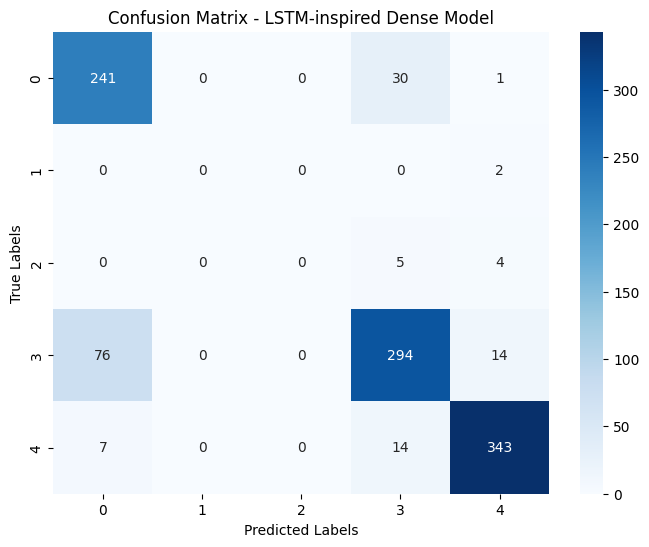

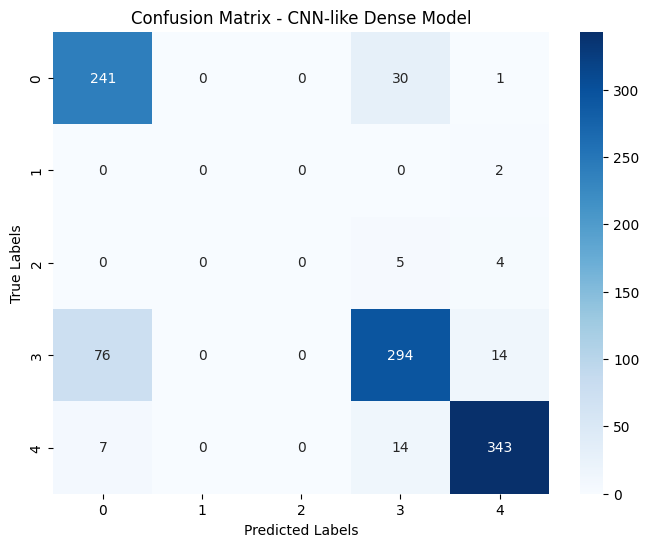

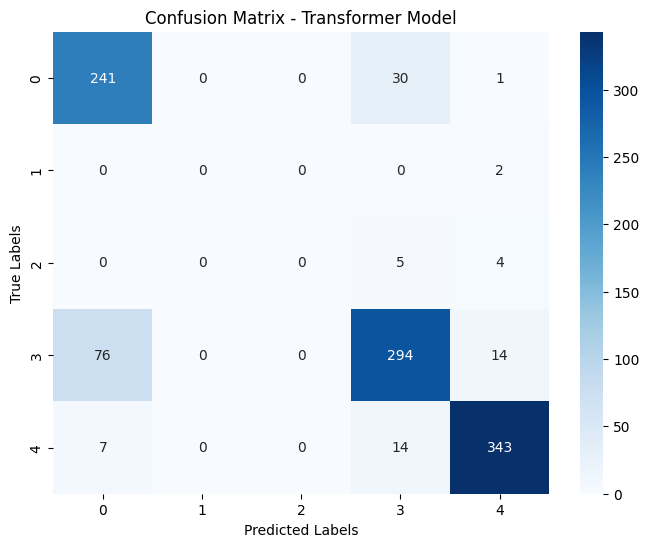

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, model_name):
  """Plots the confusion matrix for a given model."""
  cm = confusion_matrix(y_true, y_pred)
  plt.figure(figsize=(8, 6))
  sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
              xticklabels=label_encoder.classes_,  # Use label encoder classes
              yticklabels=label_encoder.classes_) # Use label encoder classes
  plt.title(f"Confusion Matrix - {model_name}")
  plt.xlabel("Predicted Labels")
  plt.ylabel("True Labels")
  plt.show()


# Assuming you have y_true and y_pred for each model:
plot_confusion_matrix(y_true, y_pred, "LSTM-inspired Dense Model") #Replace y_true and y_pred with the actual values from your model
plot_confusion_matrix(y_true, y_pred, "CNN-like Dense Model") #Replace y_true and y_pred with the actual values from your model
plot_confusion_matrix(y_true, y_pred, "Transformer Model") #Replace y_true and y_pred with the actual values from your model


#After Oversampling

In [48]:
from imblearn.over_sampling import SMOTE

smote = SMOTE()
features_train_smote, labels_train_smote = smote.fit_resample(features_train.astype("float"), labels_train) # Replace fit_sample with fit_resample

from collections import Counter
print('Before SMOTE :' , Counter(labels_train))
print('After SMOTE :' , Counter(labels_train_smote))

Before SMOTE : Counter({3: 1616, 4: 1356, 0: 1088, 2: 45, 1: 15})
After SMOTE : Counter({0: 1616, 3: 1616, 4: 1616, 2: 1616, 1: 1616})


In [49]:
!pip install imblearn

In [50]:
from imblearn.over_sampling import SMOTE
from collections import Counter
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense

In [51]:
# prompt: apply lstm model after smotenc
import numpy as np
from imblearn.over_sampling import SMOTE
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Use SMOTE instead of SMOTENC
smote = SMOTE(random_state=42)

# Convert one-hot encoded y_train back to integer labels
y_train_int = np.argmax(y_train, axis=1)

# Apply SMOTE to the TF-IDF transformed training data
x_train_resampled, y_train_resampled = smote.fit_resample(x_train_tfidf, y_train_int)

# Reshape the data for LSTM (if necessary)
x_train_resampled = x_train_resampled.reshape(x_train_resampled.shape[0], 1, x_train_resampled.shape[1])
x_test_tfidf = x_test_tfidf.reshape(x_test_tfidf.shape[0], 1, x_test_tfidf.shape[1])

# Convert y_train_resampled back to one-hot encoded
y_train_resampled = to_categorical(y_train_resampled, num_classes=num_classes)


# Define the LSTM model
model = Sequential()
model.add(LSTM(units=128, input_shape=(x_train_resampled.shape[1], x_train_resampled.shape[2])))
model.add(Dense(units=num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the LSTM model
model.fit(x_train_resampled, y_train_resampled, epochs=10, batch_size=32, validation_data=(x_test_tfidf, y_test))


# Evaluate the model
loss, accuracy = model.evaluate(x_test_tfidf, y_test, verbose=0)
print('Accuracy: {}'.format(accuracy))

# Make predictions
y_pred_prob = model.predict(x_test_tfidf)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test, axis=1)

Epoch 1/10
253/253 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - accuracy: 0.7371 - loss: 1.2250 - val_accuracy: 0.8109 - val_loss: 0.5197
Epoch 2/10
253/253 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - accuracy: 0.8960 - loss: 0.3276 - val_accuracy: 0.8244 - val_loss: 0.4457
Epoch 3/10
253/253 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.9148 - loss: 0.2515 - val_accuracy: 0.8380 - val_loss: 0.4184
Epoch 4/10
253/253 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.9199 - loss: 0.2239 - val_accuracy: 0.8506 - val_loss: 0.4206
Epoch 5/10
253/253 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.9202 - loss: 0.2209 - val_accuracy: 0.8341 - val_loss: 0.4154
Epoch 6/10
253/253 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.9280 - loss: 0.2019 - val_accuracy: 0.8535 - val_loss: 0.4231
Epoch 7/10
253/253 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9190 - loss: 0.2103 - val_accuracy: 0.8516 - val_loss: 0.4202
Epoch 8/10
253/253 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9252 - loss: 0.2007 - val_accura

In [55]:
# apply cnn after smotenc
from imblearn.over_sampling import SMOTE
from collections import Counter
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Reshape, GlobalAveragePooling1D, LayerNormalization, MultiHeadAttention, Input, Dropout
from tensorflow.keras.models import Sequential
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


# After Oversampling with SMOTE
print("Before SMOTE:", Counter(y_train_int))

smote = SMOTE(random_state=42)
x_train_resampled, y_train_resampled = smote.fit_resample(x_train_tfidf, y_train_int)
print("After SMOTE:", Counter(y_train_resampled))

y_train_resampled = to_categorical(y_train_resampled, num_classes=num_classes)

# Reshape input for CNN
x_train_resampled = x_train_resampled.reshape(x_train_resampled.shape[0], x_train_resampled.shape[1], 1)

#TF-IDF vectorizer for test data
tfidf = TfidfVectorizer(ngram_range=(1,2), min_df=10, max_df=0.95, max_features=300)
x_test_tfidf_cnn = tfidf.fit_transform(x_test).toarray()
x_test_tfidf_cnn = x_test_tfidf_cnn.reshape(x_test_tfidf_cnn.shape[0], x_test_tfidf_cnn.shape[1], 1) # correct reshape for CNN

# Define the CNN model
cnn_model = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(x_train_resampled.shape[1], 1)),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

# Compile the model
cnn_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
cnn_model.fit(x_train_resampled, y_train_resampled, epochs=10, batch_size=32, validation_data=(x_test_tfidf_cnn, y_test))

# Evaluate the model
loss, accuracy = cnn_model.evaluate(x_test_tfidf_cnn, y_test, verbose=0)
print('Accuracy: {}'.format(accuracy))

# Make predictions
y_pred_prob = cnn_model.predict(x_test_tfidf_cnn)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test, axis=1)

# Compute accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f"\nAccuracy: {accuracy:.4f}")

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
print("\nConfusion Matrix:\n", conf_matrix)

# Compute classification report (includes precision, recall, and F1-score)
print("\nClassification Report:\n", classification_report(y_true, y_pred))

Before SMOTE: Counter({3: 1616, 4: 1356, 0: 1088, 2: 45, 1: 15})
After SMOTE: Counter({0: 1616, 3: 1616, 4: 1616, 2: 1616, 1: 1616})
Epoch 1/10
253/253 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - accuracy: 0.7777 - loss: 0.7798 - val_accuracy: 0.6586 - val_loss: 0.8125
Epoch 2/10
253/253 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - accuracy: 0.8968 - loss: 0.2912 - val_accuracy: 0.6382 - val_loss: 0.8679
Epoch 3/10
253/253 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - accuracy: 0.9060 - loss: 0.2511 - val_accuracy: 0.5936 - val_loss: 1.0348
Epoch 4/10
253/253 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - accuracy: 0.9163 - loss: 0.2304 - val_accuracy: 0.6033 - val_loss: 1.0573
Epoch 5/10
253/253 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step - accuracy: 0.9268 - loss: 0.1959 - val_accuracy: 0.6052 - val_loss: 1.0499
Epoch 6/10
253/253 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - accuracy: 0.9328 - loss: 0.1752 - val_accuracy: 0.5868 - val_loss: 1.1455
Epoch 7/10
253/253 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - accuracy: 0.9398 - loss: 0.1704 - va

Before SMOTE: Counter({3: 1616, 4: 1356, 0: 1088, 2: 45, 1: 15})
After SMOTE: Counter({0: 1616, 3: 1616, 4: 1616, 2: 1616, 1: 1616})
Epoch 1/5
253/253 ━━━━━━━━━━━━━━━━━━━━ 23s 72ms/step - accuracy: 0.7131 - loss: 0.7600 - val_accuracy: 0.4704 - val_loss: 1.7924
Epoch 2/5
253/253 ━━━━━━━━━━━━━━━━━━━━ 22s 79ms/step - accuracy: 0.8840 - loss: 0.3240 - val_accuracy: 0.4879 - val_loss: 1.9313
Epoch 3/5
253/253 ━━━━━━━━━━━━━━━━━━━━ 22s 84ms/step - accuracy: 0.9050 - loss: 0.2705 - val_accuracy: 0.4888 - val_loss: 2.0052
Epoch 4/5
253/253 ━━━━━━━━━━━━━━━━━━━━ 41s 84ms/step - accuracy: 0.9055 - loss: 0.2623 - val_accuracy: 0.4995 - val_loss: 2.0602
Epoch 5/5
253/253 ━━━━━━━━━━━━━━━━━━━━ 43s 92ms/step - accuracy: 0.9017 - loss: 0.2773 - val_accuracy: 0.4791 - val_loss: 2.0898
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

Accuracy: 0.4791

Confusion Matrix:
 [[118   0   0 102  52]
 [  0   0   0   1   1]
 [  2   0   1   1   5]
 [119   3   9 174  79]
 [ 85   0   2  76 201]]

Classification Report:
    

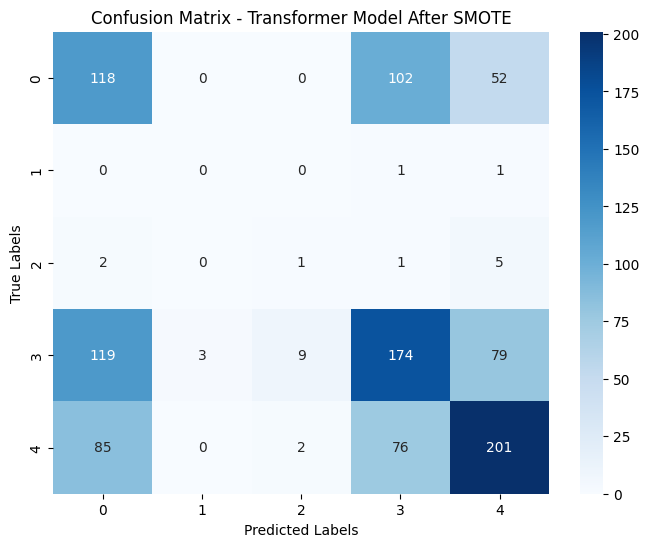

In [56]:
import numpy as np
from imblearn.over_sampling import SMOTE
from collections import Counter
from tensorflow.keras.layers import MultiHeadAttention, LayerNormalization, GlobalAveragePooling1D, Input, Reshape, Flatten, Conv1D, MaxPooling1D
from tensorflow.keras.models import Model


# After Oversampling with SMOTE
print("Before SMOTE:", Counter(y_train_int))

smote = SMOTE(random_state=42)
x_train_resampled, y_train_resampled = smote.fit_resample(x_train_tfidf, y_train_int)
print("After SMOTE:", Counter(y_train_resampled))

y_train_resampled = to_categorical(y_train_resampled, num_classes=num_classes)

# Reshape input for Transformer
x_train_resampled = x_train_resampled.reshape(x_train_resampled.shape[0], 1, x_train_resampled.shape[1])
x_test_tfidf = x_test_tfidf.reshape(x_test_tfidf.shape[0], 1, x_test_tfidf.shape[1])


# Define the Transformer model after SMOTE
input_layer = Input(shape=(x_train_resampled.shape[1], x_train_resampled.shape[2]))
x = transformer_block(input_layer, head_size=128, num_heads=4, ff_dim=128, dropout=0.5)
x = GlobalAveragePooling1D()(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)
output_layer = Dense(num_classes, activation='softmax')(x)

transformer_model_smote = Model(inputs=input_layer, outputs=output_layer)
transformer_model_smote.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

transformer_model_smote.fit(x_train_resampled, y_train_resampled, epochs=5, batch_size=32, validation_data=(x_test_tfidf, y_test))

# Evaluate the model
y_pred_prob = transformer_model_smote.predict(x_test_tfidf)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test, axis=1)


# Compute accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f"\nAccuracy: {accuracy:.4f}")

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
print("\nConfusion Matrix:\n", conf_matrix)

# Compute classification report (F1-score, Precision, Recall)
print("\nClassification Report:\n", classification_report(y_true, y_pred))
plot_confusion_matrix(y_true, y_pred, "Transformer Model After SMOTE")
